# **Installing dependencies**

In [ ]:
!pip uninstall numpy pandas scikit-learn datasets transformers torch torchvision -y

!pip install numpy==1.26.4 pandas==2.2.3 scikit-learn==1.5.2 datasets==2.21.0 transformers==4.48.0 torch==2.4.1 torchvision==0.19.1 --quiet

In [ ]:
import json
import os
import pandas as pd
import numpy as np
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from tqdm import tqdm
import torchvision
import datasets
import transformers
import sklearn
import json
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.metrics import precision_recall_fscore_support

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

drive.mount('/content/drive', force_remount=False)
print("Google Drive mounted successfully")

# **1. Data Preprocessing**

In [2]:
# Defining proficiency map
proficiency_map = {'Beginner': 1, 'Intermediate': 2, 'Advanced': 3}

# Synthetic Student Profile Dataset (15000 samples)
n_samples = 15000
proficiency = np.random.choice(['Beginner', 'Intermediate', 'Advanced'], n_samples, p=[0.333, 0.333, 0.334])
score_ranges = {'Beginner': (50, 70), 'Intermediate': (65, 85), 'Advanced': (80, 100)}
past_scores = np.array([np.random.uniform(score_ranges[p][0], score_ranges[p][1]) for p in proficiency])

student_data = {
    'student_id': [f'S{i}' for i in range(n_samples)],
    'age': np.random.randint(18, 25, n_samples),
    'grade': np.random.choice(['Freshman', 'Sophomore', 'Junior', 'Senior'], n_samples),
    'courses': np.random.choice(['NLP', 'Data Structures', 'Databases', 'Cybersecurity'], n_samples, p=[0.25, 0.25, 0.25, 0.25]),
    'past_scores': past_scores,
    'topics_mastered': np.random.choice(['NLP Basics', 'Algorithms', 'SQL', 'Security Fundamentals'], n_samples),
    'proficiency': proficiency
}
student_df = pd.DataFrame(student_data)

# Encode categorical features
le_grade = LabelEncoder()
le_courses = LabelEncoder()
le_topics = LabelEncoder()
le_proficiency = LabelEncoder()

student_df['grade'] = le_grade.fit_transform(student_df['grade'])
student_df['courses'] = le_courses.fit_transform(student_df['courses'])
student_df['topics_mastered'] = le_topics.fit_transform(student_df['topics_mastered'])
student_df['proficiency'] = le_proficiency.fit_transform(student_df['proficiency'])

# Scale numerical features
scaler = StandardScaler()
student_df[['age', 'past_scores']] = scaler.fit_transform(student_df[['age', 'past_scores']])

# Rename proficiency to labels
student_df = student_df.rename(columns={'proficiency': 'labels'})

# Debug: Print class distribution and score correlation
print("Class distribution:", student_df['labels'].value_counts())
print("Average past_scores by proficiency:", student_df.groupby('labels')['past_scores'].mean())

Class distribution: labels
1    5039
2    5034
0    4927
Name: count, dtype: int64
Average past_scores by proficiency: labels
0    1.120617
1   -1.103514
2    0.007812
Name: past_scores, dtype: float64


# **Preparing input text for DistilBERT**

In [3]:
# Creating input_text column
student_df['input_text'] = student_df.apply(
    lambda x: f"Course: {le_courses.inverse_transform([int(x['courses'])])[0]}, "
              f"Topic Mastered: {le_topics.inverse_transform([int(x['topics_mastered'])])[0]}, "
              f"Past Score: {x['past_scores']:.2f}, "
              f"Grade: {le_grade.inverse_transform([int(x['grade'])])[0]}",
    axis=1
)

In [4]:
# Splitting dataset into train, validation, and test sets
train_df, temp_df = train_test_split(student_df, test_size=0.3, random_state=42, stratify=student_df['labels'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['labels'])

# Converting to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=3,
    dropout=0.1,
    attention_dropout=0.1
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def tokenize_function(examples):
    return tokenizer(examples['input_text'], padding='max_length', truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Removing non-essential columns to avoid Arrow-to-NumPy conversion issues
train_dataset = train_dataset.remove_columns([col for col in train_dataset.column_names if col not in ['input_ids', 'attention_mask', 'labels']])
val_dataset = val_dataset.remove_columns([col for col in val_dataset.column_names if col not in ['input_ids', 'attention_mask', 'labels']])
test_dataset = test_dataset.remove_columns([col for col in test_dataset.column_names if col not in ['input_ids', 'attention_mask', 'labels']])

# Setting format for PyTorch
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

sample = train_dataset[0]
print("Train dataset sample:", {
    'input_ids': sample['input_ids'].tolist()[:10],  # Convert to list and show first 10 tokens for brevity
    'attention_mask': sample['attention_mask'].tolist()[:10],  # Convert to list
    'labels': sample['labels'].item()  # Convert scalar tensor to Python int
})

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/10500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2250 [00:00<?, ? examples/s]

Map:   0%|          | 0/2250 [00:00<?, ? examples/s]

Train dataset sample: {'input_ids': [101, 2607, 1024, 16941, 3366, 10841, 15780, 1010, 8476, 15682], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': 1}


# **3. Model Training**

In [5]:
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    report_to='none',
    fp16=torch.cuda.is_available(),
    gradient_accumulation_steps=2,
    warmup_steps=100
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return {'accuracy': accuracy, 'f1': f1}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)


In [6]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.255900,0.235724,0.842222,0.840957
2,0.251000,0.230517,0.837778,0.827067
3,0.254600,0.228444,0.835556,0.840129
4,0.225600,0.230392,0.833333,0.837974
5,0.231600,0.227749,0.842667,0.841470
6,0.242800,0.225657,0.837778,0.833525
7,0.237800,0.226038,0.845333,0.843995
8,0.227500,0.230872,0.842667,0.843497
9,0.222000,0.232151,0.836000,0.836640


TrainOutput(global_step=6560, training_loss=0.24313661761400177, metrics={'train_runtime': 484.4491, 'train_samples_per_second': 216.741, 'train_steps_per_second': 13.541, 'total_flos': 3472429845722112.0, 'train_loss': 0.24313661761400177, 'epoch': 9.985529322162986})

In [7]:
# Saving model and tokenizer
model.save_pretrained('/content/drive/MyDrive/personalization_model')
tokenizer.save_pretrained('/content/drive/MyDrive/personalization_model')
print("Model saved successfully")

Model saved successfully


# **4. Personalization Function**

In [8]:
questions_data = {
    'question': [f"Question {i}" for i in range(100)],
    'topic': np.random.choice(['NLP', 'Data Structures', 'Databases', 'Cybersecurity'], 100),
    'difficulty': np.random.choice(['Beginner', 'Intermediate', 'Advanced'], 100),
    'difficulty_num': np.random.choice([1, 2, 3], 100)
}
questions_df = pd.DataFrame(questions_data)

# Related topic mapping for fallback
related_topics = {
    'NLP': ['Data Structures', 'Databases'],
    'Data Structures': ['NLP', 'Databases'],
    'Databases': ['Data Structures', 'Cybersecurity'],
    'Cybersecurity': ['Databases', 'NLP']
}

# Personalization function
def personalize_exam(student_profile, questions_df, model, tokenizer, num_questions=5):
    input_text = f"Course: {le_courses.inverse_transform([int(student_profile['courses'])])[0]}, " \
                 f"Topic Mastered: {le_topics.inverse_transform([int(student_profile['topics_mastered'])])[0]}, " \
                 f"Past Score: {student_profile['past_scores']:.2f}, " \
                 f"Grade: {le_grade.inverse_transform([int(student_profile['grade'])])[0]}"
    inputs = tokenizer(input_text, return_tensors='pt', padding=True, truncation=True, max_length=128).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        predicted_proficiency = torch.argmax(outputs.logits, dim=1).item()

    predicted_proficiency_label = le_proficiency.inverse_transform([predicted_proficiency])[0]
    proficiency_num = proficiency_map[predicted_proficiency_label]

    # Debug: Print student course and proficiency
    student_course = le_courses.inverse_transform([int(student_profile['courses'])])[0]
    print(f"Student Course: {student_course}, Predicted Proficiency: {predicted_proficiency_label}")

    # Try course-specific questions
    candidate_questions = questions_df[questions_df['topic'] == student_course]
    filtered_questions = candidate_questions[
        abs(candidate_questions['difficulty_num'] - proficiency_num) <= 1
    ]

    # Fallback 1: All difficulties for course
    if len(filtered_questions) == 0:
        filtered_questions = candidate_questions
        print(f"No questions match difficulty {proficiency_num}±1 for {student_course}, using all difficulties")

    # Fallback 2: Related topics with matching difficulty
    if len(filtered_questions) == 0:
        related = related_topics.get(student_course, ['NLP'])
        candidate_questions = questions_df[questions_df['topic'].isin(related)]
        filtered_questions = candidate_questions[
            abs(candidate_questions['difficulty_num'] - proficiency_num) <= 1
        ]
        print(f"No questions found for course {student_course}, using related topics {related}")

    # Fallback 3: Any topic with matching difficulty
    if len(filtered_questions) == 0:
        filtered_questions = questions_df[abs(questions_df['difficulty_num'] - proficiency_num) <= 1]
        print(f"No questions found for related topics, using any topic with difficulty {proficiency_num}±1")

    # Select questions
    if len(filtered_questions) >= num_questions:
        selected_questions = filtered_questions.sample(num_questions, random_state=42)
    elif len(filtered_questions) > 0:
        selected_questions = filtered_questions
    else:
        selected_questions = pd.DataFrame(columns=candidate_questions.columns)
        print(f"No suitable questions found")

    return selected_questions, predicted_proficiency_label

# **5. Evaluation**

Test Results: {'eval_loss': 0.23389366269111633, 'eval_accuracy': 0.8382222222222222, 'eval_f1': 0.8365044837214944, 'eval_runtime': 2.1528, 'eval_samples_per_second': 1045.174, 'eval_steps_per_second': 130.995, 'epoch': 9.985529322162986}


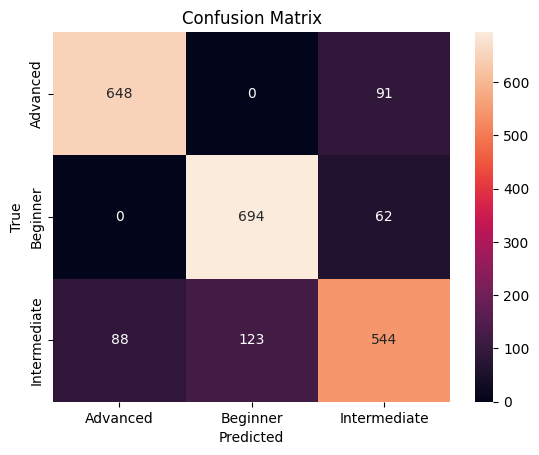

Evaluating personalization:   1%|          | 15/2250 [00:00<00:32, 69.53it/s]

Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Pro

Evaluating personalization:   2%|▏         | 34/2250 [00:00<00:26, 84.38it/s]

Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Intermediate
Student Cour

Evaluating personalization:   2%|▏         | 54/2250 [00:00<00:23, 91.69it/s]

Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: NLP, Predicte

Evaluating personalization:   3%|▎         | 74/2250 [00:00<00:22, 95.30it/s]

Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Databases,

Evaluating personalization:   4%|▍         | 95/2250 [00:01<00:22, 97.12it/s]

Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Studen

Evaluating personalization:   5%|▌         | 116/2250 [00:01<00:21, 99.78it/s]

Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Databa

Evaluating personalization:   6%|▌         | 138/2250 [00:01<00:20, 101.54it/s]

Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Intermediate
Studen

Evaluating personalization:   7%|▋         | 160/2250 [00:01<00:20, 101.59it/s]

Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Databases,

Evaluating personalization:   8%|▊         | 182/2250 [00:01<00:20, 101.81it/s]

Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Data

Evaluating personalization:   9%|▉         | 204/2250 [00:02<00:20, 101.91it/s]

Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Prof

Evaluating personalization:  10%|▉         | 215/2250 [00:02<00:19, 102.10it/s]

Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course

Evaluating personalization:  11%|█         | 237/2250 [00:02<00:19, 102.60it/s]

Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Advance

Evaluating personalization:  12%|█▏        | 259/2250 [00:02<00:19, 102.13it/s]

Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Intermediate
Studen

Evaluating personalization:  12%|█▏        | 281/2250 [00:02<00:19, 102.31it/s]

Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Co

Evaluating personalization:  13%|█▎        | 303/2250 [00:03<00:18, 102.77it/s]

Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course

Evaluating personalization:  14%|█▍        | 325/2250 [00:03<00:18, 103.02it/s]

Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency

Evaluating personalization:  15%|█▌        | 347/2250 [00:03<00:18, 103.23it/s]

Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Data Structures, Pre

Evaluating personalization:  16%|█▋        | 369/2250 [00:03<00:18, 102.23it/s]

Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
St

Evaluating personalization:  17%|█▋        | 391/2250 [00:03<00:18, 102.45it/s]

Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: NLP, P

Evaluating personalization:  18%|█▊        | 413/2250 [00:04<00:18, 101.65it/s]

Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Cybe

Evaluating personalization:  19%|█▉        | 435/2250 [00:04<00:17, 101.29it/s]

Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Stud

Evaluating personalization:  20%|██        | 457/2250 [00:04<00:17, 102.07it/s]

Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: NLP, P

Evaluating personalization:  21%|██        | 468/2250 [00:04<00:17, 102.77it/s]

Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: 

Evaluating personalization:  22%|██▏       | 490/2250 [00:04<00:17, 103.14it/s]

Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: I

Evaluating personalization:  23%|██▎       | 512/2250 [00:05<00:16, 103.31it/s]

Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted P

Evaluating personalization:  24%|██▎       | 534/2250 [00:05<00:16, 103.31it/s]

Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: NLP, P

Evaluating personalization:  25%|██▍       | 556/2250 [00:05<00:17, 98.45it/s] 

Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Beginner
Student Co

Evaluating personalization:  26%|██▌       | 577/2250 [00:05<00:17, 97.53it/s]

Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: 

Evaluating personalization:  27%|██▋       | 599/2250 [00:05<00:16, 99.66it/s]

Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Beginner


Evaluating personalization:  28%|██▊       | 621/2250 [00:06<00:16, 98.80it/s] 

Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Data

Evaluating personalization:  29%|██▊       | 642/2250 [00:06<00:16, 99.33it/s]

Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Ad

Evaluating personalization:  30%|██▉       | 664/2250 [00:06<00:15, 100.90it/s]

Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency:

Evaluating personalization:  30%|███       | 686/2250 [00:06<00:15, 102.93it/s]

Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Data Structures, Predict

Evaluating personalization:  31%|███▏      | 708/2250 [00:07<00:14, 103.07it/s]

Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Inter

Evaluating personalization:  32%|███▏      | 730/2250 [00:07<00:14, 103.32it/s]

Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Cybersecurity,

Evaluating personalization:  33%|███▎      | 752/2250 [00:07<00:14, 103.63it/s]

Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Data Structures, P

Evaluating personalization:  34%|███▍      | 774/2250 [00:07<00:14, 103.60it/s]

Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Begin

Evaluating personalization:  35%|███▌      | 796/2250 [00:07<00:13, 104.02it/s]

Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Profi

Evaluating personalization:  36%|███▋      | 818/2250 [00:08<00:13, 104.13it/s]

Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicte

Evaluating personalization:  37%|███▋      | 840/2250 [00:08<00:13, 103.89it/s]

Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Advanced
St

Evaluating personalization:  38%|███▊      | 862/2250 [00:08<00:13, 103.13it/s]

Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Cour

Evaluating personalization:  39%|███▉      | 873/2250 [00:08<00:13, 103.13it/s]

Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Data Structu

Evaluating personalization:  40%|███▉      | 895/2250 [00:08<00:13, 103.39it/s]

Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Profic

Evaluating personalization:  41%|████      | 917/2250 [00:09<00:12, 103.53it/s]

Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Co

Evaluating personalization:  42%|████▏     | 950/2250 [00:09<00:12, 104.39it/s]

Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Cy

Evaluating personalization:  43%|████▎     | 972/2250 [00:09<00:12, 105.39it/s]

Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Data Structures, Predi

Evaluating personalization:  44%|████▍     | 994/2250 [00:09<00:11, 106.18it/s]

Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency:

Evaluating personalization:  45%|████▌     | 1016/2250 [00:10<00:11, 105.93it/s]

Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Data Str

Evaluating personalization:  46%|████▌     | 1027/2250 [00:10<00:11, 105.24it/s]

Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Intermediate
Student Cour

Evaluating personalization:  47%|████▋     | 1049/2250 [00:10<00:11, 104.22it/s]

Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Stud

Evaluating personalization:  48%|████▊     | 1071/2250 [00:10<00:11, 103.59it/s]

Student Course: NLP, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Intermediat

Evaluating personalization:  49%|████▊     | 1093/2250 [00:10<00:11, 103.56it/s]

Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency

Evaluating personalization:  50%|████▉     | 1115/2250 [00:10<00:11, 102.07it/s]

Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted

Evaluating personalization:  51%|█████     | 1137/2250 [00:11<00:10, 102.62it/s]

Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Studen

Evaluating personalization:  52%|█████▏    | 1159/2250 [00:11<00:10, 102.98it/s]

Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Intermediate
St

Evaluating personalization:  52%|█████▏    | 1181/2250 [00:11<00:10, 102.87it/s]

Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: NLP, Predi

Evaluating personalization:  53%|█████▎    | 1203/2250 [00:11<00:10, 100.44it/s]

Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Beginner


Evaluating personalization:  54%|█████▍    | 1225/2250 [00:12<00:09, 102.71it/s]

Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Cybersecurity,

Evaluating personalization:  55%|█████▌    | 1247/2250 [00:12<00:09, 102.17it/s]

Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Intermedi

Evaluating personalization:  56%|█████▌    | 1258/2250 [00:12<00:09, 102.23it/s]

Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted

Evaluating personalization:  57%|█████▋    | 1280/2250 [00:12<00:09, 101.64it/s]

Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Co

Evaluating personalization:  58%|█████▊    | 1302/2250 [00:12<00:09, 101.22it/s]

Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Prof

Evaluating personalization:  59%|█████▉    | 1324/2250 [00:13<00:09, 102.06it/s]

Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Beginner
St

Evaluating personalization:  60%|█████▉    | 1346/2250 [00:13<00:08, 103.05it/s]

Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Databases, Predi

Evaluating personalization:  61%|██████    | 1368/2250 [00:13<00:08, 103.74it/s]

Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: NLP,

Evaluating personalization:  62%|██████▏   | 1390/2250 [00:13<00:08, 103.93it/s]

Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: B

Evaluating personalization:  63%|██████▎   | 1412/2250 [00:13<00:08, 103.33it/s]

Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Co

Evaluating personalization:  64%|██████▎   | 1434/2250 [00:14<00:07, 103.10it/s]

Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student 

Evaluating personalization:  65%|██████▍   | 1456/2250 [00:14<00:07, 104.00it/s]

Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Data Structures, Predi

Evaluating personalization:  66%|██████▌   | 1478/2250 [00:14<00:07, 103.73it/s]

Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Studen

Evaluating personalization:  67%|██████▋   | 1500/2250 [00:14<00:07, 103.45it/s]

Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Cour

Evaluating personalization:  68%|██████▊   | 1522/2250 [00:14<00:07, 103.57it/s]

Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Databases, P

Evaluating personalization:  69%|██████▊   | 1544/2250 [00:15<00:06, 103.92it/s]

Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Begi

Evaluating personalization:  70%|██████▉   | 1566/2250 [00:15<00:06, 104.89it/s]

Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
St

Evaluating personalization:  71%|███████   | 1588/2250 [00:15<00:06, 105.70it/s]

Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Be

Evaluating personalization:  72%|███████▏  | 1610/2250 [00:15<00:06, 106.21it/s]

Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficien

Evaluating personalization:  73%|███████▎  | 1632/2250 [00:15<00:05, 105.06it/s]

Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Databases, Pre

Evaluating personalization:  74%|███████▎  | 1654/2250 [00:16<00:05, 103.85it/s]

Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Databases, Predict

Evaluating personalization:  74%|███████▍  | 1676/2250 [00:16<00:05, 103.50it/s]

Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Cour

Evaluating personalization:  75%|███████▌  | 1698/2250 [00:16<00:05, 102.99it/s]

Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Intermediate


Evaluating personalization:  76%|███████▋  | 1720/2250 [00:16<00:05, 103.43it/s]

Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: 

Evaluating personalization:  77%|███████▋  | 1742/2250 [00:17<00:04, 103.82it/s]

Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course

Evaluating personalization:  78%|███████▊  | 1764/2250 [00:17<00:04, 103.52it/s]

Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Be

Evaluating personalization:  79%|███████▉  | 1775/2250 [00:17<00:04, 103.28it/s]

Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Data Structures, Predict

Evaluating personalization:  80%|████████  | 1808/2250 [00:17<00:04, 104.17it/s]

Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Beginner
Student Course:

Evaluating personalization:  81%|████████▏ | 1830/2250 [00:17<00:03, 105.17it/s]

Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Advanced
Studen

Evaluating personalization:  82%|████████▏ | 1841/2250 [00:18<00:03, 104.67it/s]

Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: 

Evaluating personalization:  83%|████████▎ | 1863/2250 [00:18<00:03, 104.01it/s]

Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Stud

Evaluating personalization:  84%|████████▍ | 1885/2250 [00:18<00:03, 104.09it/s]

Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Databa

Evaluating personalization:  85%|████████▍ | 1907/2250 [00:18<00:03, 103.66it/s]

Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Data

Evaluating personalization:  86%|████████▌ | 1929/2250 [00:18<00:03, 104.56it/s]

Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency

Evaluating personalization:  87%|████████▋ | 1951/2250 [00:19<00:02, 104.29it/s]

Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: I

Evaluating personalization:  88%|████████▊ | 1973/2250 [00:19<00:02, 103.59it/s]

Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Profi

Evaluating personalization:  89%|████████▊ | 1995/2250 [00:19<00:02, 103.02it/s]

Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Beginne

Evaluating personalization:  90%|████████▉ | 2017/2250 [00:19<00:02, 104.01it/s]

Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Pro

Evaluating personalization:  91%|█████████ | 2039/2250 [00:19<00:02, 104.09it/s]

Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Databa

Evaluating personalization:  92%|█████████▏| 2061/2250 [00:20<00:01, 104.01it/s]

Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: NLP, P

Evaluating personalization:  93%|█████████▎| 2083/2250 [00:20<00:01, 103.76it/s]

Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Advanced
St

Evaluating personalization:  94%|█████████▎| 2105/2250 [00:20<00:01, 103.90it/s]

Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner


Evaluating personalization:  95%|█████████▍| 2127/2250 [00:20<00:01, 103.84it/s]

Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted

Evaluating personalization:  96%|█████████▌| 2149/2250 [00:20<00:00, 103.76it/s]

Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Advanced
St

Evaluating personalization:  96%|█████████▋| 2171/2250 [00:21<00:00, 104.58it/s]

Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: NLP, Pre

Evaluating personalization:  97%|█████████▋| 2193/2250 [00:21<00:00, 104.95it/s]

Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Cour

Evaluating personalization:  98%|█████████▊| 2215/2250 [00:21<00:00, 100.54it/s]

Student Course: Databases, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Data Structures, Predict

Evaluating personalization:  99%|█████████▉| 2237/2250 [00:21<00:00, 102.74it/s]

Student Course: Data Structures, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Intermediate
Student Course: Data Structures, Predicted Proficiency: Advanced
Student Course: Cybersecurity, Predicted Proficiency: Beginner
Student Course: Data Structures, Predicted Proficiency: Intermediate
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Advanced
St

Evaluating personalization: 100%|██████████| 2250/2250 [00:21<00:00, 102.41it/s]


Student Course: Cybersecurity, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: NLP, Predicted Proficiency: Advanced
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: NLP, Predicted Proficiency: Beginner
Student Course: Databases, Predicted Proficiency: Intermediate
Student Course: Databases, Predicted Proficiency: Beginner
Student Course: Cybersecurity, Predicted Proficiency: Advanced
Average Alignment Rate: 1.0000
Average Difficulty Suitability (MAE): 0.5666
Results saved to /content/drive/MyDrive/personalization_results.json


In [9]:
# Evaluate model on test set
test_results = trainer.evaluate(test_dataset)
print("Test Results:", test_results)

# Confusion Matrix
predictions = trainer.predict(test_dataset).predictions
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_df['labels'].values
cm = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le_proficiency.classes_, yticklabels=le_proficiency.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('/content/drive/MyDrive/confusion_matrix.png')
plt.show()

# Personalization Evaluation
alignment_rates = []
difficulty_diffs = []
for idx, student in tqdm(test_df.iterrows(), total=len(test_df), desc="Evaluating personalization"):
    selected_questions, predicted_proficiency = personalize_exam(student, questions_df, model, tokenizer)

    # Handle empty selected_questions
    if len(selected_questions) == 0:
        alignment = 0
        diff = np.nan
    else:
        student_course = le_courses.inverse_transform([int(student['courses'])])[0]
        alignment = len(selected_questions[selected_questions['topic'] == student_course]) / len(selected_questions)
        proficiency_num = proficiency_map[le_proficiency.inverse_transform([int(student['labels'])])[0]]
        diff = np.mean(abs(selected_questions['difficulty_num'] - proficiency_num))

    alignment_rates.append(alignment)
    difficulty_diffs.append(diff)

# Filter out NaN for mean calculation
difficulty_diffs = [d for d in difficulty_diffs if not np.isnan(d)]
print(f"Average Alignment Rate: {np.mean(alignment_rates):.4f}")
print(f"Average Difficulty Suitability (MAE): {np.mean(difficulty_diffs):.4f}" if difficulty_diffs else "No valid difficulty differences")

results = {
    'test_accuracy': test_results['eval_accuracy'],
    'test_f1': test_results['eval_f1'],
    'alignment_rate': np.mean(alignment_rates),
    'difficulty_suitability': np.mean(difficulty_diffs) if difficulty_diffs else None
}
with open('/content/drive/MyDrive/personalization_results.json', 'w') as f:
    json.dump(results, f, indent=4)
print("Results saved to /content/drive/MyDrive/personalization_results.json")

# **Inference**

In [10]:
def infer_student_exam(student_profile, questions_df, model, tokenizer, le_grade, le_courses, le_topics, le_proficiency, scaler, proficiency_map, num_questions=5):
    profile_df = pd.DataFrame([student_profile])

    # Encoding categorical features
    profile_df['grade'] = le_grade.transform(profile_df['grade'])
    profile_df['courses'] = le_courses.transform(profile_df['courses'])
    profile_df['topics_mastered'] = le_topics.transform(profile_df['topics_mastered'])

    # Scaling numerical features
    profile_df[['age', 'past_scores']] = scaler.transform(profile_df[['age', 'past_scores']])

    profile_df['input_text'] = profile_df.apply(
        lambda x: f"Course: {le_courses.inverse_transform([int(x['courses'])])[0]}, "
                  f"Topic Mastered: {le_topics.inverse_transform([int(x['topics_mastered'])])[0]}, "
                  f"Past Score: {x['past_scores']:.2f}, "
                  f"Grade: {le_grade.inverse_transform([int(x['grade'])])[0]}",
        axis=1
    )

    # Predicting proficiency
    inputs = tokenizer(profile_df['input_text'].iloc[0], return_tensors='pt', padding=True, truncation=True, max_length=128).to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        predicted_proficiency = torch.argmax(outputs.logits, dim=1).item()

    predicted_proficiency_label = le_proficiency.inverse_transform([predicted_proficiency])[0]

    # Gettnig personalized questions
    selected_questions, _ = personalize_exam(profile_df.iloc[0], questions_df, model, tokenizer, num_questions)

    print(f"\nStudent Profile: {student_profile}")
    print(f"Predicted Proficiency: {predicted_proficiency_label}")
    print("\nSelected Questions:")
    if len(selected_questions) == 0:
        print("No suitable questions found.")
    else:
        for idx, q in selected_questions.iterrows():
            print(f"Question {idx+1}: {q['question']} (Topic: {q['topic']}, Difficulty: {q['difficulty']})")

    return predicted_proficiency_label, selected_questions

# Example on real student profiles
real_students = [
    {
        'age': 20,
        'grade': 'Sophomore',
        'courses': 'NLP',
        'past_scores': 85.0,
        'topics_mastered': 'NLP Basics'
    },
    {
        'age': 22,
        'grade': 'Junior',
        'courses': 'Databases',
        'past_scores': 65.0,
        'topics_mastered': 'SQL'
    },
    {
        'age': 19,
        'grade': 'Freshman',
        'courses': 'Cybersecurity',
        'past_scores': 55.0,
        'topics_mastered': 'Security Fundamentals'
    }
]

# Run inference for each student
for student in real_students:
    predicted_proficiency, selected_questions = infer_student_exam(
        student, questions_df, model, tokenizer, le_grade, le_courses, le_topics, le_proficiency, scaler, proficiency_map
    )

Student Course: NLP, Predicted Proficiency: Advanced

Student Profile: {'age': 20, 'grade': 'Sophomore', 'courses': 'NLP', 'past_scores': 85.0, 'topics_mastered': 'NLP Basics'}
Predicted Proficiency: Advanced

Selected Questions:
Question 63: Question 62 (Topic: NLP, Difficulty: Beginner)
Question 68: Question 67 (Topic: NLP, Difficulty: Advanced)
Question 3: Question 2 (Topic: NLP, Difficulty: Intermediate)
Question 73: Question 72 (Topic: NLP, Difficulty: Intermediate)
Question 36: Question 35 (Topic: NLP, Difficulty: Advanced)
Student Course: Databases, Predicted Proficiency: Beginner

Student Profile: {'age': 22, 'grade': 'Junior', 'courses': 'Databases', 'past_scores': 65.0, 'topics_mastered': 'SQL'}
Predicted Proficiency: Beginner

Selected Questions:
Question 1: Question 0 (Topic: Databases, Difficulty: Advanced)
Question 4: Question 3 (Topic: Databases, Difficulty: Intermediate)
Question 14: Question 13 (Topic: Databases, Difficulty: Beginner)
Question 79: Question 78 (Topic: D

# **Evaluating with evaluation Metrics**

In [11]:
test_results = trainer.evaluate(test_dataset)
print("Test Results:", test_results)

# Get predictions for test set
predictions = trainer.predict(test_dataset)
logits = predictions.predictions
predicted_labels = np.argmax(logits, axis=1)
true_labels = test_df['labels'].values

precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average=None, labels=[0, 1, 2])
class_names = le_proficiency.classes_  # ['Beginner', 'Intermediate', 'Advanced']

print("\nPer-Class Metrics:")
for i, class_name in enumerate(class_names):
    print(f"{class_name}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1-Score: {f1[i]:.4f}")

macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='macro')
weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
print("\nAggregate Metrics:")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1-Score: {macro_f1:.4f}")
print(f"Weighted Precision: {weighted_precision:.4f}")
print(f"Weighted Recall: {weighted_recall:.4f}")
print(f"Weighted F1-Score: {weighted_f1:.4f}")


Test Results: {'eval_loss': 0.23389366269111633, 'eval_accuracy': 0.8382222222222222, 'eval_f1': 0.8365044837214944, 'eval_runtime': 2.1842, 'eval_samples_per_second': 1030.129, 'eval_steps_per_second': 129.11, 'epoch': 9.985529322162986}

Per-Class Metrics:
Advanced:
  Precision: 0.8804
  Recall: 0.8769
  F1-Score: 0.8786
Beginner:
  Precision: 0.8494
  Recall: 0.9180
  F1-Score: 0.8824
Intermediate:
  Precision: 0.7805
  Recall: 0.7205
  F1-Score: 0.7493

Aggregate Metrics:
Macro Precision: 0.8368
Macro Recall: 0.8385
Macro F1-Score: 0.8368
Weighted Precision: 0.8365
Weighted Recall: 0.8382
Weighted F1-Score: 0.8365


# **Normalized Confusion Matrix**

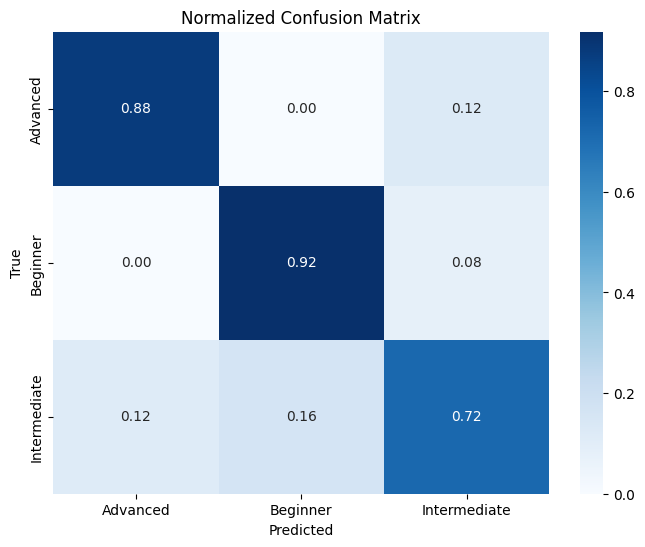

In [12]:
# Compute normalized confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=[0, 1, 2], normalize='true')
class_names = le_proficiency.classes_  # ['Beginner', 'Intermediate', 'Advanced']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.savefig('/content/drive/MyDrive/normalized_confusion_matrix.png')
plt.show()

**The normalized confusion matrix reveals high accuracy with 0.88 of Advanced, 0.92 of Beginner, and 0.72 of Intermediate students correctly classified**

# **Learning Curves**

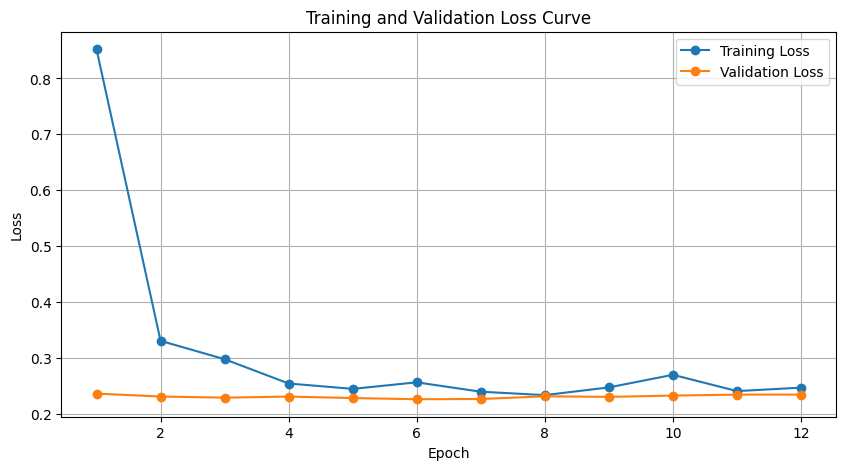

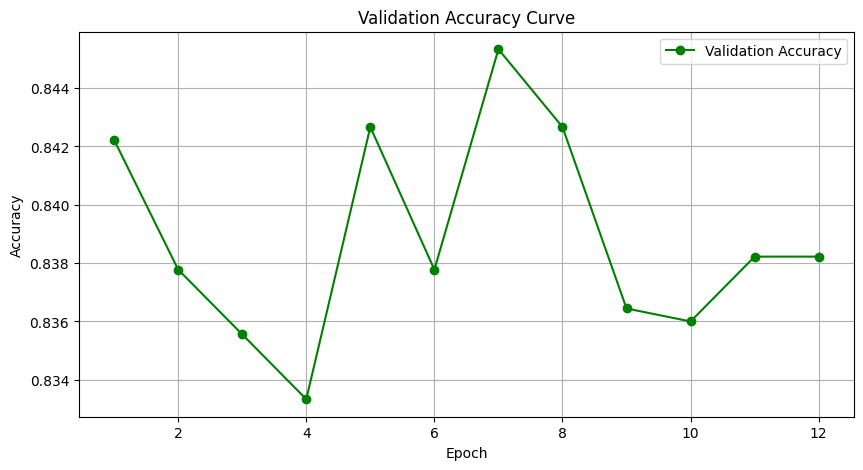

In [13]:
# Extracting training logs
train_logs = trainer.state.log_history
train_loss = [log['loss'] for log in train_logs if 'loss' in log]
val_loss = [log['eval_loss'] for log in train_logs if 'eval_loss' in log]
val_accuracy = [log['eval_accuracy'] for log in train_logs if 'eval_accuracy' in log]
epochs = range(1, len(val_loss) + 1)

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss[:len(epochs)], label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.savefig('/content/drive/MyDrive/learning_curve_loss.png')
plt.show()

# Plot Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Curve')
plt.legend()
plt.grid(True)
plt.savefig('/content/drive/MyDrive/learning_curve_accuracy.png')
plt.show()


**The training and validation loss curves show a sharp initial drop in training loss from 0.80 to 0.23 over 12 epochs, while validation loss remains stable at 0.20, indicating good model convergence; the validation accuracy curve peaks at 0.845 at epoch 5 but stabilizes around 0.838, suggesting consistent but slightly variable performance.**

# **ROC Curves (One-vs-Rest)**

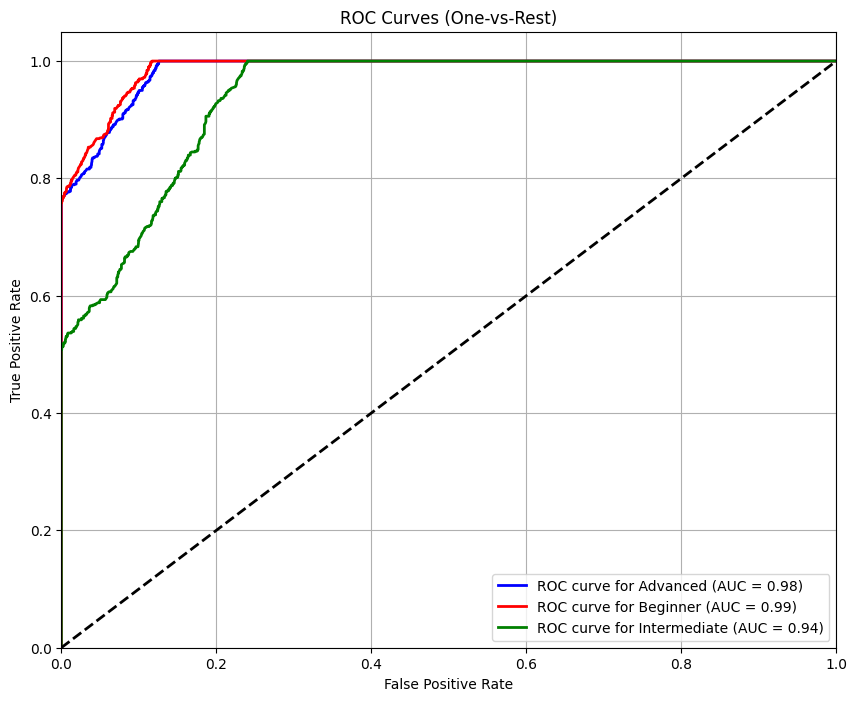

In [14]:
# Convert labels to one-hot encoding for ROC
n_classes = len(le_proficiency.classes_)
true_labels_one_hot = np.zeros((len(true_labels), n_classes))
for i, label in enumerate(true_labels):
    true_labels_one_hot[i, label] = 1

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_one_hot[:, i], logits[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green'])
class_names = le_proficiency.classes_
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve for {class_names[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('/content/drive/MyDrive/roc_curves.png')
plt.show()


The ROC curves demonstrate excellent model performance with AUCs of 0.98
(Advanced), 0.99 (Beginner), and 0.94 (Intermediate), indicating strong class
separation.

# **Class Distribution Plot**

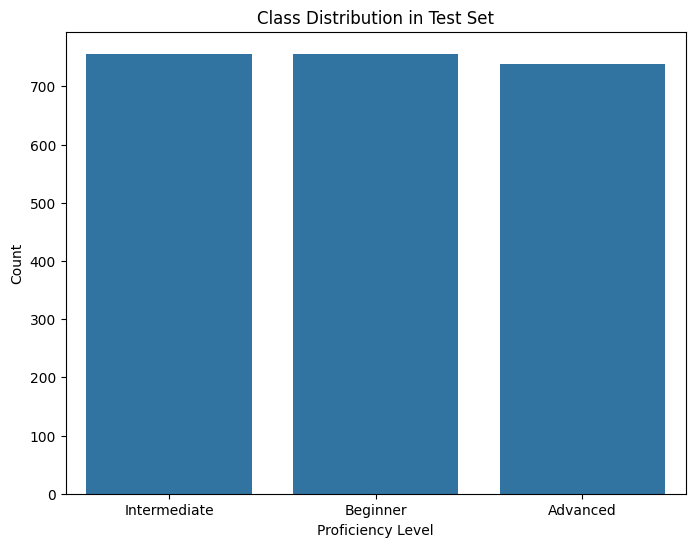

In [15]:
# Class Distribution Plot
class_names = le_proficiency.classes_
plt.figure(figsize=(8, 6))
sns.countplot(x=test_df['labels'].map({i: class_names[i] for i in range(len(class_names))}))
plt.xlabel('Proficiency Level')
plt.ylabel('Count')
plt.title('Class Distribution in Test Set')
plt.savefig('/content/drive/MyDrive/class_distribution.png')
plt.show()


# **Score Correlation Plot**

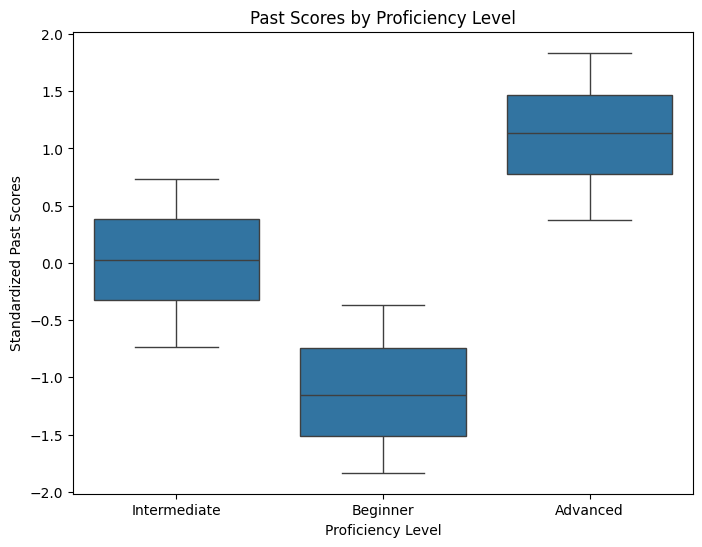

In [16]:
# Score Correlation Plot (Past Scores vs. Proficiency)
class_names = le_proficiency.classes_
plt.figure(figsize=(8, 6))
sns.boxplot(x=test_df['labels'].map({i: class_names[i] for i in range(len(class_names))}), y=test_df['past_scores'])
plt.xlabel('Proficiency Level')
plt.ylabel('Standardized Past Scores')
plt.title('Past Scores by Proficiency Level')
plt.savefig('/content/drive/MyDrive/score_correlation.png')
plt.show()


# **Saving Extended Results**

In [17]:
results = {
    'test_accuracy': test_results['eval_accuracy'],
    'test_f1': test_results['eval_f1'],
    'per_class_precision': {le_proficiency.classes_[i]: precision[i] for i in range(len(le_proficiency.classes_))},
    'per_class_recall': {le_proficiency.classes_[i]: recall[i] for i in range(len(le_proficiency.classes_))},
    'per_class_f1': {le_proficiency.classes_[i]: f1[i] for i in range(len(le_proficiency.classes_))},
    'macro_precision': macro_precision,
    'macro_recall': macro_recall,
    'macro_f1': macro_f1,
    'weighted_precision': weighted_precision,
    'weighted_recall': weighted_recall,
    'weighted_f1': weighted_f1,
    'roc_auc': {le_proficiency.classes_[i]: roc_auc[i] for i in range(len(le_proficiency.classes_))},
    'alignment_rate': np.mean(alignment_rates),  # From previous evaluation
    'difficulty_suitability': np.mean(difficulty_diffs) if difficulty_diffs else None
}
with open('/content/drive/MyDrive/extended_results.json', 'w') as f:
    json.dump(results, f, indent=4)
print("Extended results saved to /content/drive/MyDrive/extended_results.json")


Extended results saved to /content/drive/MyDrive/extended_results.json
